In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib

from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import sklearn.datasets as dt
import scipy
import hdbscan

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from sklearn.utils import resample
from tensorflow.keras.datasets.fashion_mnist import load_data

#Import all the algorithms
from umap import UMAP
import openTSNE
from openTSNE import TSNE as OpenTSNE
from openTSNE import affinity, initialization, TSNEEmbedding

import time

In [14]:
def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7
sns_styleset()

In [15]:
def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X.iloc[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X.iloc[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

In [16]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype('int')
X_whitened = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X_whitened, full_matrices=False)
X784 = np.dot(U, np.diag(s))[:,:784]

In [17]:
n = X784.shape[0]

In [18]:
embed =[]
%time embed.append(PCA(n_components=2).fit_transform(X))
%time embed.append(OpenTSNE(n_jobs=-1, random_state=42).fit(X784))
#Multi-Scale kernel
%time affinities_multiscale_mix = affinity.Multiscale(X784, perplexities=[30, int(X.shape[0]/100)], n_jobs=-1, random_state=42)
%time pca_init = initialization.pca(X, random_state=42)
%time embedding0 = TSNEEmbedding(pca_init,affinities_multiscale_mix,negative_gradient_method="fft",n_jobs=-1, random_state=42)
%time embedding1 = embedding0.optimize(n_iter=250, exaggeration=12, momentum=0.5)
%time embed.append(embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.5))
#Learning Rate adjusted
%time affinities_multiscale_mix = affinity.Multiscale(X784, perplexities=[30, int(X.shape[0]/100)], n_jobs=-1, random_state=42)
%time pca_init = initialization.pca(X, random_state=42)
%time embedding0 = TSNEEmbedding(pca_init,affinities_multiscale_mix,n/12,negative_gradient_method="fft",n_jobs=-1, random_state=42)
%time embedding1 = embedding0.optimize(n_iter=250, exaggeration=12, momentum=0.5)
%time embed.append(embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.5))
%time embed.append(UMAP(random_state=42, init='random').fit_transform(X))
%time embed.append(UMAP(random_state=42).fit_transform(X))

CPU times: user 17.1 s, sys: 3.73 s, total: 20.8 s
Wall time: 2.05 s
CPU times: user 8min 30s, sys: 18.3 s, total: 8min 49s
Wall time: 2min 44s
CPU times: user 55min 52s, sys: 42.7 s, total: 56min 34s
Wall time: 6min 15s
CPU times: user 16.5 s, sys: 4.15 s, total: 20.6 s
Wall time: 2.17 s
CPU times: user 59 µs, sys: 320 µs, total: 379 µs
Wall time: 384 µs
CPU times: user 7min 46s, sys: 2.53 s, total: 7min 49s
Wall time: 7min 50s
CPU times: user 23min 4s, sys: 14.9 s, total: 23min 19s
Wall time: 23min 23s
CPU times: user 54min 45s, sys: 42.7 s, total: 55min 28s
Wall time: 6min 4s
CPU times: user 15.7 s, sys: 4.77 s, total: 20.4 s
Wall time: 2.06 s
CPU times: user 39 µs, sys: 69 µs, total: 108 µs
Wall time: 111 µs
CPU times: user 7min 37s, sys: 2.56 s, total: 7min 39s
Wall time: 7min 41s
CPU times: user 22min 44s, sys: 7.44 s, total: 22min 52s
Wall time: 22min 56s
CPU times: user 1min 25s, sys: 2.96 s, total: 1min 28s
Wall time: 44.4 s
CPU times: user 2min 5s, sys: 4.41 s, total: 2min 9s

In [19]:
%%time
metrics = []
for Z in embed:
    knn, knc, cpd = embedding_quality(X, Z, y, knn=10, knn_classes=4, subsetsize=1000)
    metrics.append((knn, knc, cpd))

CPU times: user 27min 24s, sys: 7min 34s, total: 34min 58s
Wall time: 10min 32s


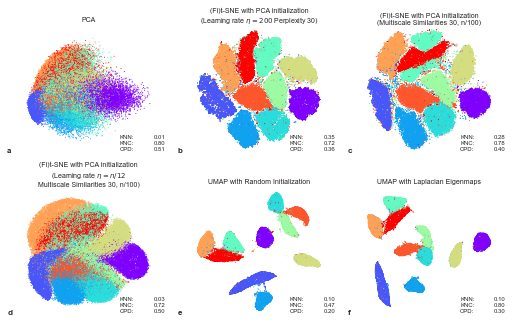

In [20]:
titles = ["PCA", "(Fi)t-SNE with PCA initialization\n(Learning rate $\eta=200$ Perplexity 30)", 
          "(Fi)t-SNE with PCA initialization\n(Multiscale Similarities 30, n/100)",
          "(Fi)t-SNE with PCA initialization\n(Learning rate $\eta=n/12$\nMultiscale Similarities 30, n/100)", "UMAP with Random Initialization",
          "UMAP with Laplacian Eigenmaps","e"]

letters = 'abcdefgh'

plt.figure(figsize=(7.2, 4.5))

dy = [0,0,0,0,0,0,0,0]
for i,Z in enumerate(embed):
    plt.subplot(2,3,1+i)
    plt.gca().set_aspect('equal', adjustable='datalim')
    rand_order = np.random.permutation(Z.shape[0])
    plt.scatter(Z[rand_order,0], Z[rand_order,1], s=1, c=y[rand_order], cmap='rainbow', 
                rasterized=True, edgecolor='none')
    plt.title(titles[i], va='center')
    plt.text(0.69,.02+dy[i],'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
    plt.text(0.9,.02+dy[i],'{:.2f}\n{:.2f}\n{:.2f}'.format(
        metrics[i][0], metrics[i][1], metrics[i][2]), transform=plt.gca().transAxes, fontsize=6)
    plt.text(0, 0, letters[i], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('digits.png', dpi=600)

In [21]:
X_whitened = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X_whitened, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]

In [22]:
#Prepare data to cluster
embeddings_to_cluster = [X]
for Z in embed:
    embeddings_to_cluster.append(Z)

clustering_labels = []
clustered_labels = []
rand_score_clustered = []
mi_score_clustered = []
rand_score = []
mi_score = []
total_capture = []

for i in range(len(embeddings_to_cluster)):
    print(i)
    if i == 0:
        clustering_labels.append(hdbscan.HDBSCAN(min_samples=10,min_cluster_size=500).fit_predict(X50))
    else:
        clustering_labels.append(hdbscan.HDBSCAN(min_samples=10,min_cluster_size=500).fit_predict(embeddings_to_cluster[i]))
    clustered = (clustering_labels[i] >= 0)
    clustered_labels.append(clustered)
    #Total Score
    rand_score.append(adjusted_rand_score(y, clustering_labels[i]))
    mi_score.append(adjusted_mutual_info_score(y, clustering_labels[i]))
    #Scores based on what was actually clustered
    rand_score_clustered.append(adjusted_rand_score(y[clustered],
                                     clustering_labels[i][clustered]))
    mi_score_clustered.append(adjusted_mutual_info_score(y[clustered], 
                                     clustering_labels[i][clustered]))
    #Total capture
    total_capture.append(np.sum(clustered) / X.shape[0])

0
/Users/idewa/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
1
2
3
4
/Users/idewa/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/Users/idewa/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
5
6


In [23]:
embed_for_cluster = [embed[1]]
for Z in embed:
    embed_for_cluster.append(Z)

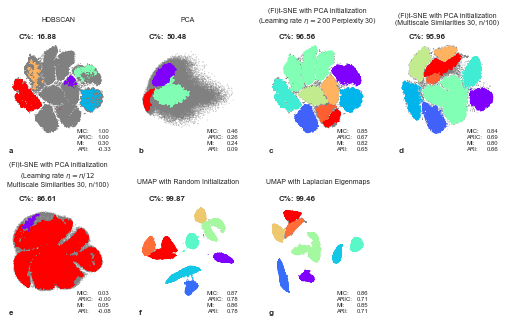

In [24]:
titles = ["HDBSCAN", "PCA", "(Fi)t-SNE with PCA initialization\n(Learning rate $\eta=200$ Perplexity 30)", 
          "(Fi)t-SNE with PCA initialization\n(Multiscale Similarities 30, n/100)",
          "(Fi)t-SNE with PCA initialization\n(Learning rate $\eta=n/12$\nMultiscale Similarities 30, n/100)", "UMAP with Random Initialization",
          "UMAP with Laplacian Eigenmaps"]

letters = 'abcdefgh'

plt.figure(figsize=(7.2, 4.5))

for i,Z in enumerate(embed_for_cluster):
    plt.subplot(2,4,1+i)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.scatter(Z[~clustered_labels[i],0], Z[~clustered_labels[i],1], s=1, color=(.5,.5,.5), alpha=0.5,
                rasterized=True, edgecolor='none')
    plt.scatter(Z[clustered_labels[i],0], Z[clustered_labels[i],1], s=1, c=clustering_labels[i][clustered_labels[i]], cmap='rainbow', 
                rasterized=True, edgecolor='none')
    plt.title(titles[i], va='center')
    plt.text(0.69,.02,'MIC:\nARIC:\nMI:\nARI:', transform=plt.gca().transAxes, fontsize=6)
    plt.text(0.90,.02,'{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}'.format( 
        mi_score_clustered[i], rand_score_clustered[i], mi_score[i], rand_score[i]),
        transform=plt.gca().transAxes, fontsize=6)
    plt.text(0.1,0.9, 'C%:', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
    plt.text(0.28,0.9, '{:.2f}'.format(total_capture[i]*100), transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
    plt.text(0, 0, letters[i], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('clustering/report/cluster_digits.png', dpi=600)

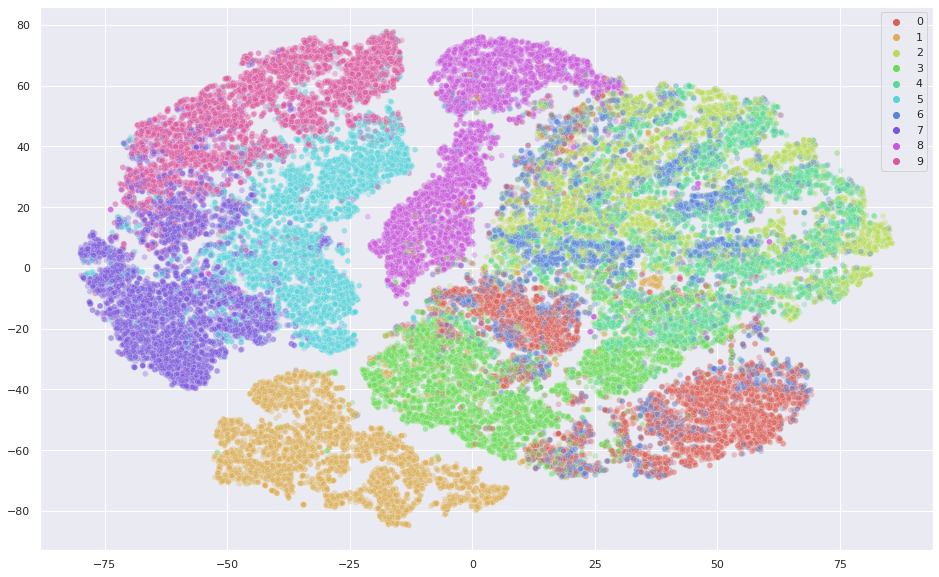

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=Z_digits[:,0], y=Z_digits[:,1],
    hue=y_train,
    palette=sns.color_palette("hls", 10),
    data=x50_train,
    legend="full",
    alpha=0.3
)

In [ ]:
tsne_norm = OpenTSNE()
%time Z_fashion = tsne_norm.fit(x50_train)

CPU times: user 3min 33s, sys: 2.13 s, total: 3min 35s
Wall time: 3min 34s


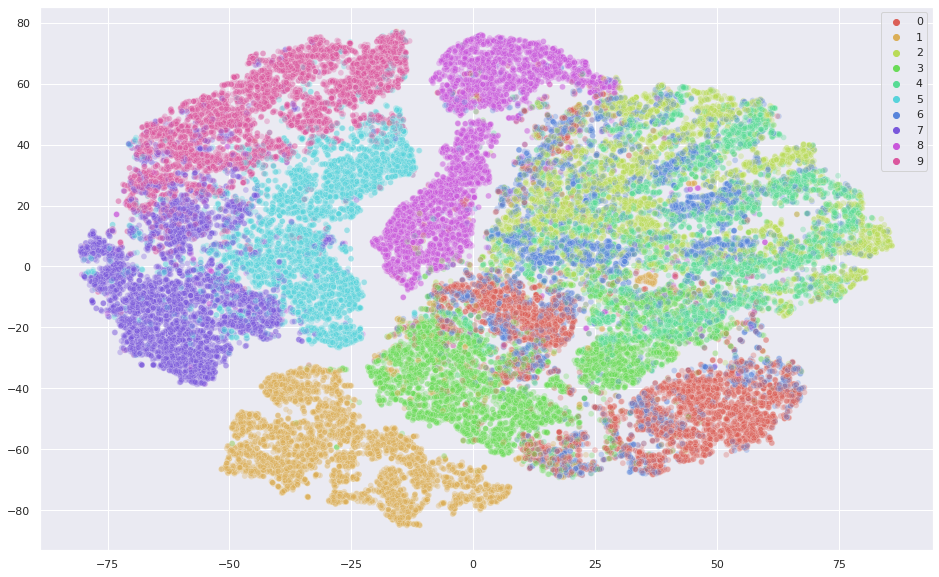

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=Z_fashion[:,0], y=Z_fashion[:,1],
    hue=y_train,
    palette=sns.color_palette("hls", 10),
    data=x50_train,
    legend="full",
    alpha=0.3
)

In [ ]:
%time Z_fashion_full = tsne_norm.fit(x_train)

CPU times: user 5min 49s, sys: 3.63 s, total: 5min 53s
Wall time: 5min 48s


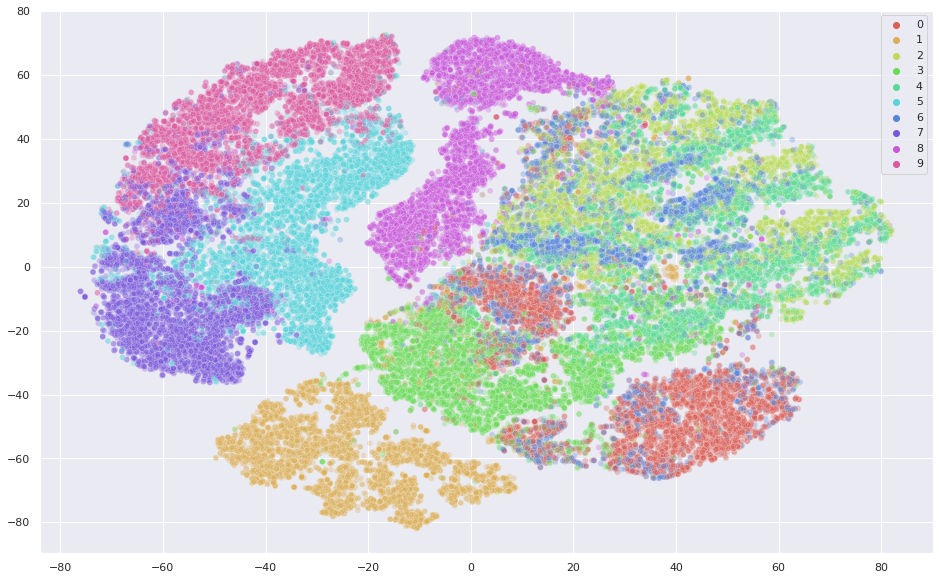

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=Z_fashion_full[:,0], y=Z_fashion_full[:,1],
    hue=y_train,
    palette=sns.color_palette("hls", 10),
    data=x_train,
    legend="full",
    alpha=0.3
)

In [ ]:
x100_train = np.dot(U, np.diag(lambd))[:,:100]
x10_train = np.dot(U, np.diag(lambd))[:,:10]
x3_train = np.dot(U, np.diag(lambd))[:,:3]

In [ ]:
%time Z_fashion_100 = tsne_norm.fit(x100_train)

CPU times: user 3min 35s, sys: 1.96 s, total: 3min 37s
Wall time: 3min 36s


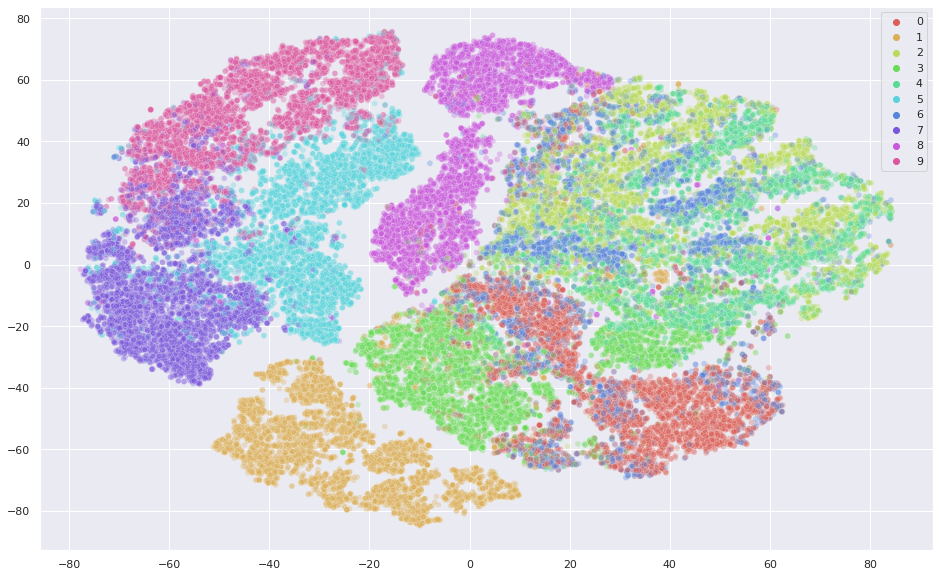

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=Z_fashion_100[:,0], y=Z_fashion_100[:,1],
    hue=y_train,
    palette=sns.color_palette("hls", 10),
    data=x_train,
    legend="full",
    alpha=0.3
)

In [ ]:
%time Z_fashion_10 = tsne_norm.fit(x10_train)

CPU times: user 3min 34s, sys: 1.44 s, total: 3min 36s
Wall time: 3min 35s


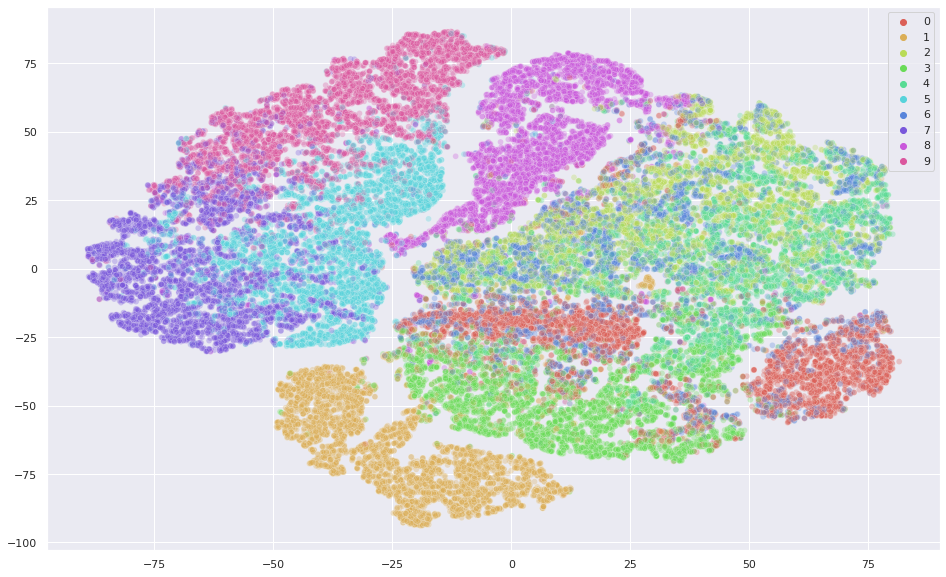

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=Z_fashion_10[:,0], y=Z_fashion_10[:,1],
    hue=y_train,
    palette=sns.color_palette("hls", 10),
    data=x_train,
    legend="full",
    alpha=0.3
)

In [ ]:
%time Z_fashion_3 = tsne_norm.fit(x3_train)

CPU times: user 3min 48s, sys: 1.25 s, total: 3min 49s
Wall time: 3min 49s


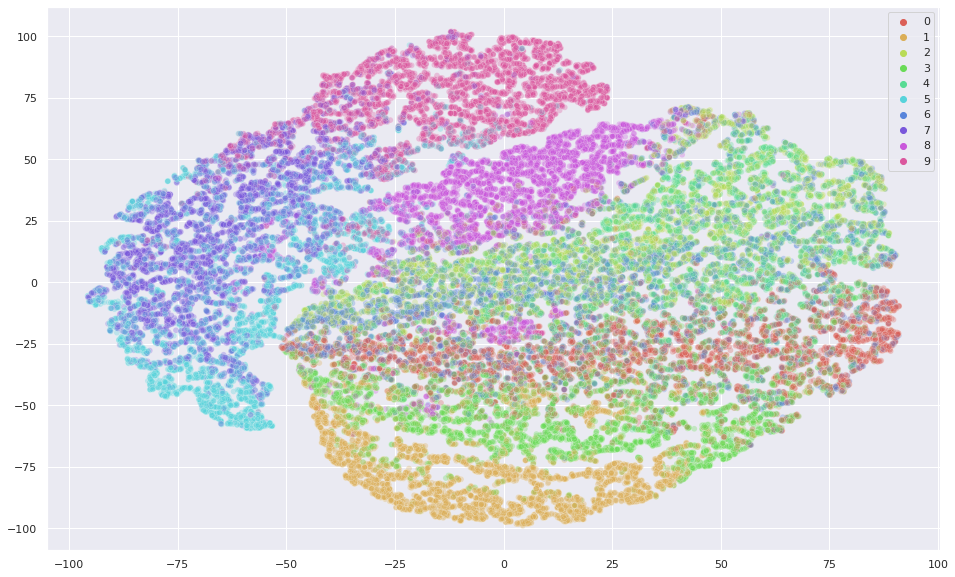

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=Z_fashion_3[:,0], y=Z_fashion_3[:,1],
    hue=y_train,
    palette=sns.color_palette("hls", 10),
    data=x_train,
    legend="full",
    alpha=0.3
)

In [ ]:

print(X.shape)

# Do PCA and keep 50 dimensions
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]

(70000, 784)


In [ ]:
col = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
                '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a'])

In [ ]:
%time Z = OpenTSNE().fit(X50)

CPU times: user 3min 49s, sys: 1.4 s, total: 3min 51s
Wall time: 3min 50s


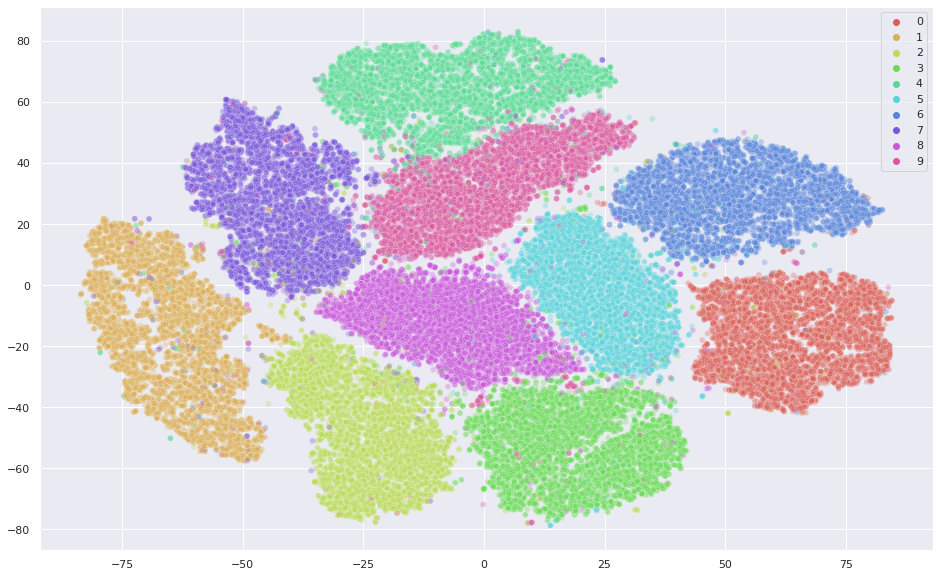

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=Z[:,0], y=Z[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    data=X50,
    legend="full",
    alpha=0.3
)